# Introduction

<img src="assets/dl_graph.jpg" width=800px>

In [2]:
import torch

## Tensors
The inputs, outputs, and transformations within neural networks are all represented using tensors, and as a result, neural network programming utilizes tensors heavily (PyTorch: `torch.Tensor`). A tensor is just a container for data, typically numerical data. It is, therefore, a container for numbers. Tensors are a generalization of matrices to any number of dimensions.

<img src="assets/scalar-vector-matrix-tensor.png" width=600px>

<img src="assets/tensor_examples.svg" width=600px>

### Example
Numpy can be used to create tensor of different dimensions such as 1D, 2D, 3D etc.

In [3]:
import torch
import numpy as np
dtype = torch.float
device = torch.device("cpu") # CPU Device

# Declaration of a tensor and initialization
a = torch.randn(2,3,device=device,dtype=dtype)
print(a)

b = torch.randn(2,3,device=device,dtype=dtype)
print(b)

print(a*b)

print(a.sum())

print(a[1,2])

print(a.min())

tensor([[ 1.0895,  0.6049,  0.6330],
        [ 0.1129,  1.3796, -1.3671]])
tensor([[-0.5028,  0.0506,  0.9334],
        [ 0.1928,  0.3943,  0.2235]])
tensor([[-0.5478,  0.0306,  0.5909],
        [ 0.0218,  0.5440, -0.3055]])
tensor(2.4529)
tensor(-1.3671)
tensor(-1.3671)


It is possible to use GPU libraries to paralelize computations.

# A single Neuron

Graphical representation
<img src="assets/einzelnes_neuron.PNG" width=400px>

$$
\begin{align}
y &= f(w_1 x_1 + w_2 x_2 + b) \\
y &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

$x_i$ - Inputs $i$ \
$w_i$ - Weights $i$ \
$b$ - Bias \
$f$ - Activation function \
$y$ - output

In [4]:
torch.manual_seed(8)
x = torch.randn((1, 5))
w = torch.randn_like(x)
b = torch.randn((1, 1))

<img src="assets/akt_fcn.jpg" width=700px>

In [5]:
def activation(x):
    """ Sigmoid activation function

        Arguments
        ---------
        x: torch.Tensor
    """
    return 1/(1+torch.exp(-x))

In [6]:
y = activation(torch.mm(x, w.view(5,1)) + b)
print(y)

tensor([[0.0803]])


# Deep Neural Networks: Fashion-MNIST (FCN)

In this notebook, we will train an MLP to classify images from the MNIST database. A regular MNIST digit dataset is actually quite trivial to classify with neural networks and you can easily achieve better than 97% accuracy. Fashion-MNIST on other hand is a set of 28x28 greyscale images (Zalando) of clothes. Comprising a training set of 60,000 examples and a test set of 10,000 examples it's a much more complex dataset than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

<img src="assets/fashion-mnist-sprite.png" width=700px>

Dataset contains **Grayscale images of a size 28×28 px**, sorted into **10 classes**:
- 0: "T-shirt/top"
- 1: "Trouser"
- 2: "Pullover"
- 3: "Dress"
- 4: "Coat"
- 5: "Sandal"
- 6: "Shirt"
- 7: "Sneaker"
- 8: "Bag"
- 9: "Ankle boot"

`DataLoader` can be used to prepare and augment the data.

In [7]:
import torch
import helper

# Define a transform to normalize the data
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), # Transformed into a tensor
                                transforms.Normalize((0.5,), (0.5,))]) # Pixel values are normalized.

# Download and load the training data (60k)
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data (10k)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:00<00:00, 94448793.13it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 3277424.62it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 47926470.94it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7944178.44it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



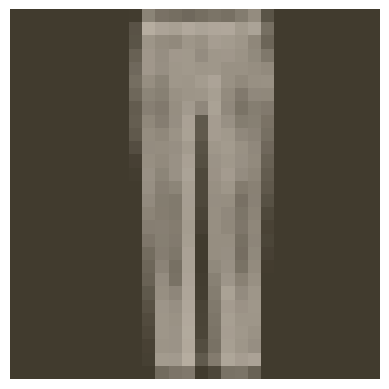

In [8]:
# Sample Image
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

In total, we will have 3 types of layers in this neural network with the neurons in one layer being connected to all other neurons from the preceeding layer:
- Input Layer: Total number of neurons is defined by the data size.
- Hidden Layer
- Output Layer: Defined depending on the actuall network application (Regression or Classification). 

Particularly for this network, we have a multiclass classification problem.

In [9]:
from torch import nn, optim

import torch.nn.functional as F

class Classifier(nn.Module):

    # Methods __init__() und forward() have to be always defined
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 256) # Fully Connected Layer
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

### Gradient Descent
In order to train an NN, we first need to find out how good or bad the current weight values are. We start with an input $x_i$ 
based on the training dateset, and the output $y_i$ will be produced. A cost (loss) function will "assess" the network performance based on the average cost of the whole dataset. There is a lo of different cost functions which can be used.

The calculated value will be smaller as the difference between the estimated and true (labeled) value becomes smaller. The main Goal of the Gradient Descent algorithm is to minimize this cost function.

Before the Training all weights and biases have to be (randomly) initialized. Thanks to the partial derivations, local gradients can be computed. This iterative process is done for the whole dataset. Once the network has seen all the datapoints, a phase named epoch is concluded and the new one can start. The total number of epochs is defined before the training process and can also be referred to as an hyperparameter.

Possible issues are that there is no guarantee that the cost function will find the global and not local minimum. Additionally, computing time can be relative long.

### Backpropagation

For the calculation of the partial derivations the Backpropagation algorithm can be used.

### Hyperparameter
Hyperparameters are those parameters that influence/define the process of the network training:
- Size of the Mini-Batch
- Number of neurons per layer
- Activation functions
- Learning rate
- Initialization of the weights and biases
- Cost function
- Number of epoch

In [10]:
# Network model will be instantiated
model = Classifier()

# Loss criterion
# PyTorch offers different possibilities
criterion = nn.NLLLoss(reduction='sum') # Negative log likelihood loss

# Mean Absolute Error Loss, Mean Squared Error Loss, Negative Log-Likelihood Loss
# Cross-Entropy Loss, Hinge Embedding Loss, Margin Ranking Loss, Triplet Margin Loss
# Kullback-Leibler divergence

# Optimization method
optimizer = optim.Adam(model.parameters(), lr=0.003) # Learning rate as an optional parameter

# Adam, Adagrad, RMSprop, AdaMax, Momentum, Adadelta

## Basis Output

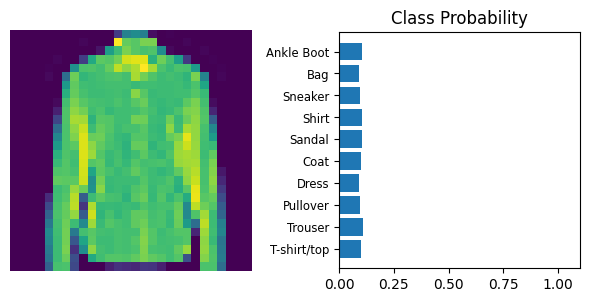

In [11]:
#%matplotlib inline

import helper

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[1]

ps = torch.exp(model(img))

helper.view_classify(img, ps, version='Fashion')

In [12]:
epochs = 5 # 1 epoch means that the network has seen all the data
# This dataset contains of 60000 images
# We have defined our Mini-Batches to have a size of 64
# This means that for one epoch requires (60000/64) = 938 iterations

train_losses = []
for e in range(epochs):

    # Training
    tot_train_loss = 0
    for images, labels in trainloader:

        # All gradients are set to zero
        optimizer.zero_grad()

        # Forwards pass
        log_ps = model(images)

        # Loss is calculated
        loss = criterion(log_ps, labels)

        # Gradients are calculated
        loss.backward()

        # Weights are updated
        optimizer.step()

        # Total training loss is calculated
        # Training loss: {tot_train_loss/len(trainloader)
        tot_train_loss += loss.item()
    else:
        train_loss = tot_train_loss / len(trainloader.dataset)
        train_losses.append(train_loss)
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss))


Epoch: 1/5..  Training Loss: 0.515.. 
Epoch: 2/5..  Training Loss: 0.393.. 
Epoch: 3/5..  Training Loss: 0.355.. 
Epoch: 4/5..  Training Loss: 0.329.. 
Epoch: 5/5..  Training Loss: 0.315.. 


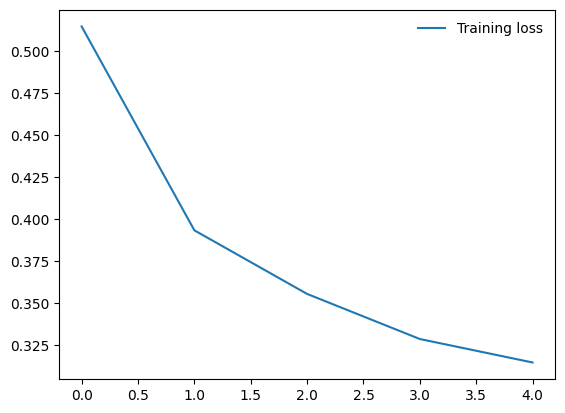

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

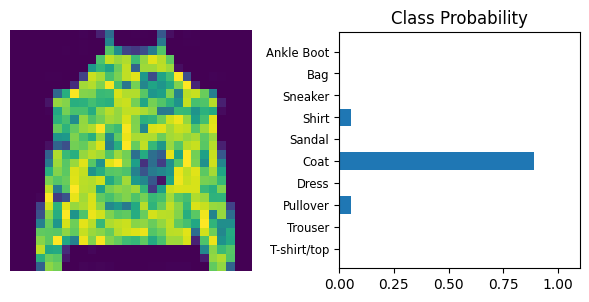

In [14]:
%matplotlib inline

import helper

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[1]

ps = torch.exp(model(img))

helper.view_classify(img, ps, version='Fashion')

## Overfitting

One of the problems that occur during neural network training is called overfitting. The error on the training set is driven to a very small value, but when new data is presented to the network the error is large. The network has memorized the training examples, but it has not learned to generalize to new situations.

In [15]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 20

train_losses, test_losses = [], []
for e in range(epochs):

    # Trainingsschleife
    tot_train_loss = 0
    for images, labels in trainloader:

        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    else:
        # Validationsschleife
        # Eine Variante der Trainingsiteration ist die Validationsiteration valid(),
        # dabei werden alle Backpropagation-Arbeitsschritte ausgelassen.
        tot_test_loss = 0
        test_correct = 0

        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/20..  Training Loss: 0.514..  Test Loss: 0.443..  Test Accuracy: 0.840
Epoch: 2/20..  Training Loss: 0.391..  Test Loss: 0.403..  Test Accuracy: 0.856
Epoch: 3/20..  Training Loss: 0.356..  Test Loss: 0.396..  Test Accuracy: 0.862
Epoch: 4/20..  Training Loss: 0.330..  Test Loss: 0.379..  Test Accuracy: 0.866
Epoch: 5/20..  Training Loss: 0.315..  Test Loss: 0.366..  Test Accuracy: 0.870
Epoch: 6/20..  Training Loss: 0.301..  Test Loss: 0.392..  Test Accuracy: 0.863
Epoch: 7/20..  Training Loss: 0.291..  Test Loss: 0.382..  Test Accuracy: 0.867
Epoch: 8/20..  Training Loss: 0.282..  Test Loss: 0.366..  Test Accuracy: 0.871
Epoch: 9/20..  Training Loss: 0.276..  Test Loss: 0.349..  Test Accuracy: 0.879
Epoch: 10/20..  Training Loss: 0.265..  Test Loss: 0.352..  Test Accuracy: 0.878
Epoch: 11/20..  Training Loss: 0.257..  Test Loss: 0.364..  Test Accuracy: 0.883
Epoch: 12/20..  Training Loss: 0.249..  Test Loss: 0.375..  Test Accuracy: 0.875
Epoch: 13/20..  Training Loss: 0.245.

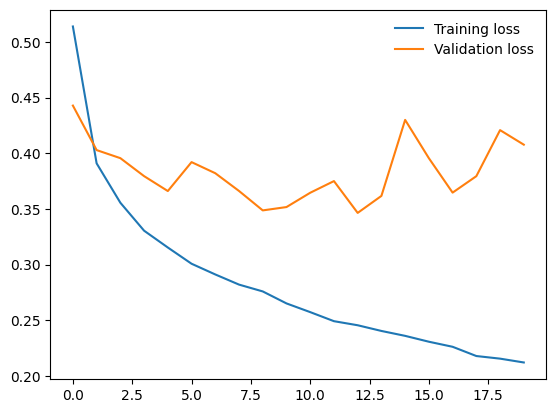

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

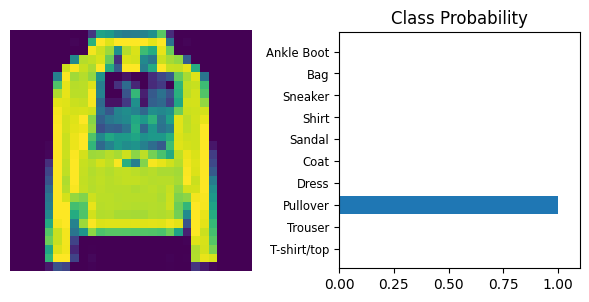

In [18]:
%matplotlib inline

import helper

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[1]

ps = torch.exp(model(img))

helper.view_classify(img, ps, version='Fashion')

The easiest thing we can do, as long as we have access to it, is to add more data. The more data we can train our model on, the more it will be able to learn from the training set. Also, with more data, we're hoping to be adding more diversity to the training set as well.

The default method for improving generalization is called early stopping. In this technique the available data is divided into three subsets. The first subset is the training set, which is used for computing the gradient and updating the network weights and biases. The second subset is the validation set. The error on the validation set is monitored during the training process. The validation error normally decreases during the initial phase of training, as does the training set error. However, when the network begins to overfit the data, the error on the validation set typically begins to rise. When the validation error increases for a specified number of iterations, the training is stopped, and the weights and biases at the minimum of the validation error are returned.

Another method for improving generalization is called regularization. This involves modifying the performance function, which is normally chosen to be the sum of squares of the network errors on the training set.

## Dropout

The general idea behind dropout is that, if you add it to a model, it will randomly ignore some subset of nodes in a given layer during training, i.e., it drops out the nodes from the layer. Hence, the name dropout. This will prevent these dropped out nodes from participating in producing a prediction on the data.

<img src="assets/dropout.PNG" width=400px>

In [19]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout with 20% probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Flattening
        x = x.view(x.shape[0], -1)

        # Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # Output Layer (kein Dropout)
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [20]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 25

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()

    else:
        tot_test_loss = 0
        test_correct = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                tot_test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        train_losses.append(tot_train_loss/len(trainloader))
        test_losses.append(tot_test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(test_correct/len(testloader)))

Epoch: 1/25..  Training Loss: 0.603..  Test Loss: 0.479..  Test Accuracy: 0.832
Epoch: 2/25..  Training Loss: 0.478..  Test Loss: 0.446..  Test Accuracy: 0.839
Epoch: 3/25..  Training Loss: 0.455..  Test Loss: 0.423..  Test Accuracy: 0.841
Epoch: 4/25..  Training Loss: 0.432..  Test Loss: 0.401..  Test Accuracy: 0.854
Epoch: 5/25..  Training Loss: 0.421..  Test Loss: 0.398..  Test Accuracy: 0.859
Epoch: 6/25..  Training Loss: 0.411..  Test Loss: 0.416..  Test Accuracy: 0.847
Epoch: 7/25..  Training Loss: 0.404..  Test Loss: 0.397..  Test Accuracy: 0.863
Epoch: 8/25..  Training Loss: 0.399..  Test Loss: 0.403..  Test Accuracy: 0.859
Epoch: 9/25..  Training Loss: 0.389..  Test Loss: 0.389..  Test Accuracy: 0.862
Epoch: 10/25..  Training Loss: 0.387..  Test Loss: 0.399..  Test Accuracy: 0.862
Epoch: 11/25..  Training Loss: 0.377..  Test Loss: 0.393..  Test Accuracy: 0.861
Epoch: 12/25..  Training Loss: 0.380..  Test Loss: 0.383..  Test Accuracy: 0.862
Epoch: 13/25..  Training Loss: 0.377.

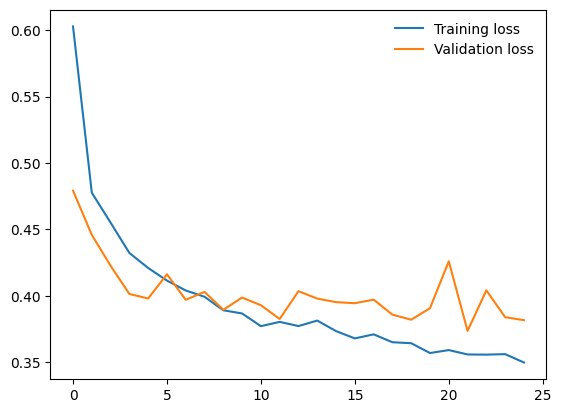

In [21]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

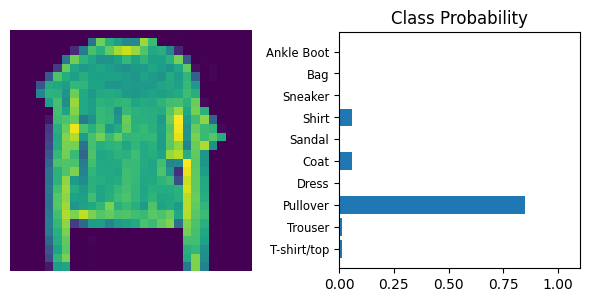

In [22]:
%matplotlib inline

import helper

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[1]

ps = torch.exp(model(img))

helper.view_classify(img, ps, version='Fashion')

# Weight Initialization

Weight initialization happens once, when a model is created and before it trains. Having good initial weights can place the neural network close to the optimal solution.

In [23]:
class Classifier(nn.Module):
    def __init__(self, constant_weight=None):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # initialize the weights to a specified, constant value
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)

        # Dropout with 20% probablitly
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Flattening
        x = x.view(x.shape[0], -1)

        # Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # Output Layer (kein Dropout)
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

## 0 vs. 1

You might think setting all the weights to 0 or 1 would be the best solution. This is not the case. With every weight having the same value, all the neurons at each layer are producing the same output. This makes it hard to decide which weights to adjust.

In [24]:
# Weight initialization
model_0 = Classifier(constant_weight=0)
model_1 = Classifier(constant_weight=1)

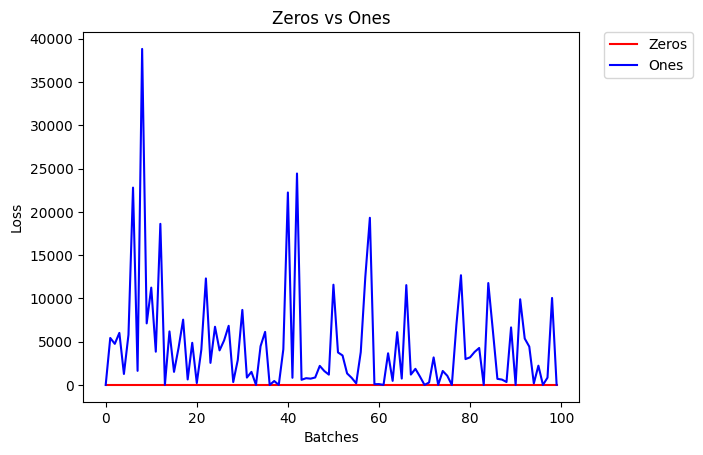

After 2 Epochs:
Validation Accuracy
   10.000% -- Zeros
   10.280% -- Ones
Training Loss
    2.302  -- Zeros
    2.305  -- Ones


In [25]:
import helpers

model_list = [(model_0, 'Zeros'),
              (model_1, 'Ones')]

helpers.compare_init_weights(model_list,
                             'Zeros vs Ones',
                             trainloader,
                             testloader)

As you can see the accuracy is close to guessing for both zeros and ones, around 10%. The neural network is having a hard time determining which weights need to be changed, since the neurons have the same output for each layer. 

## Uniform Distribution
A uniform distribution has the equal probability of picking any number from a set of numbers. We'll be picking from a continuous distribution, so the chance of picking the same number is low.

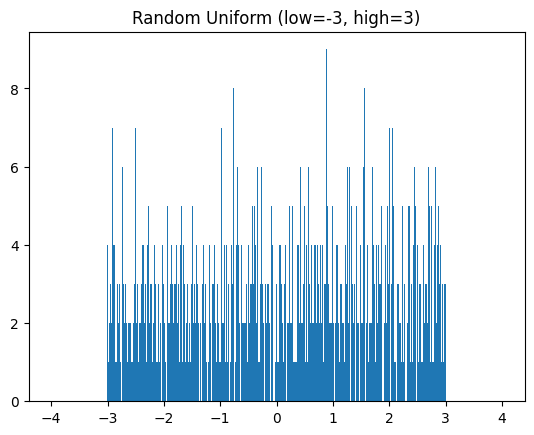

In [34]:
helpers.hist_dist('Random Uniform (low=-3, high=3)', np.random.uniform(-3, 3, [1000])) # Outputs random values from a uniform distribution.

The histogram used 500 buckets for the 1000 values. Since the chance for any single bucket is the same, there should be around 2 values for each bucket. That's exactly what we see with the histogram. Some buckets have more and some have less, but they trend around 2.

### Uniform Initialization, Baseline

Here we will see how well the neural network trains when using a uniform weight initialization, where low=0.0 and high=1.0

In [35]:
def weights_init_uniform(m):
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

model_uniform = Classifier()
model_uniform.apply(weights_init_uniform)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

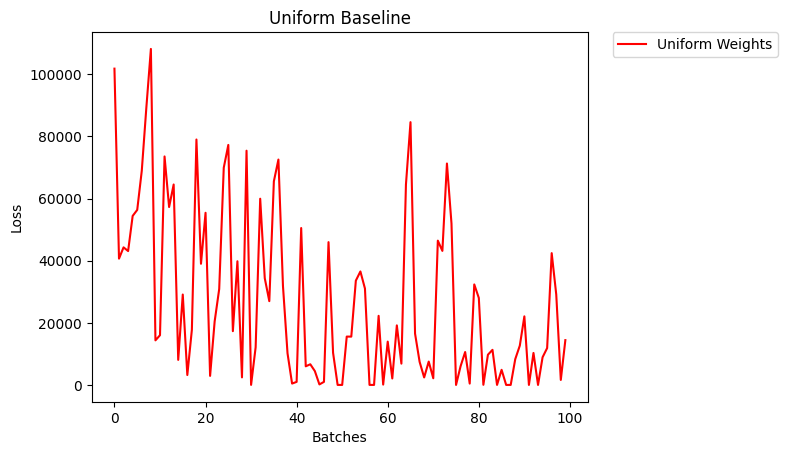

After 2 Epochs:
Validation Accuracy
   10.130% -- Uniform Weights
Training Loss
    2.299  -- Uniform Weights


In [36]:
helpers.compare_init_weights([(model_uniform, 'Uniform Weights')],
                             'Uniform Baseline',
                             trainloader,
                             testloader)

The loss graph is showing the neural network is learning, which it didn't with all zeros or all ones.

## General rule for setting weights

The general rule for setting the weights in a neural network is to set them to be close to zero without being too small.

Good practice is to start your weights in the range of `[-y, y]` where `y=1/sqrt(n)` (`n` is the number of inputs to a given neuron).

In [31]:
def weights_init_uniform_center(m):
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        m.weight.data.uniform_(-0.5, 0.5)
        m.bias.data.fill_(0)

model_centered = Classifier()
model_centered.apply(weights_init_uniform_center)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [32]:
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

model_rule = Classifier()
model_rule.apply(weights_init_uniform_rule)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

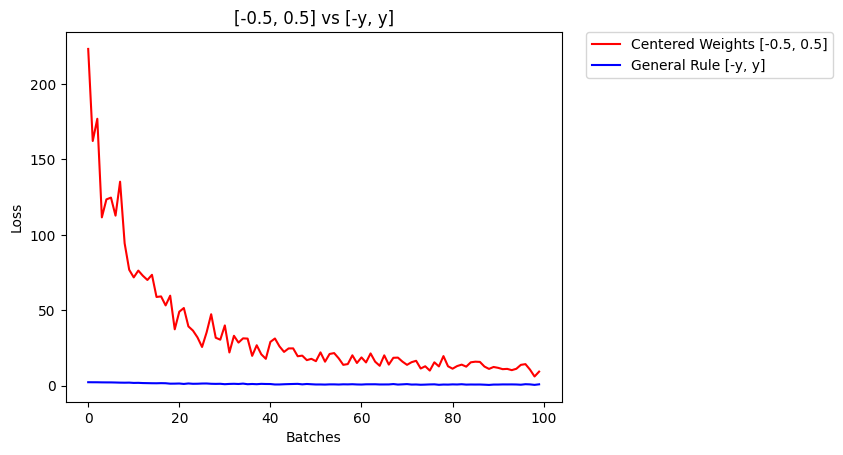

After 2 Epochs:
Validation Accuracy
   67.740% -- Centered Weights [-0.5, 0.5]
   83.060% -- General Rule [-y, y]
Training Loss
    0.715  -- Centered Weights [-0.5, 0.5]
    0.313  -- General Rule [-y, y]


In [33]:
model_list = [(model_centered, 'Centered Weights [-0.5, 0.5]'),
              (model_rule, 'General Rule [-y, y]')]

helpers.compare_init_weights(model_list,
                             '[-0.5, 0.5] vs [-y, y]',
                             trainloader,
                             testloader)

## Normal Distribution

Unlike the uniform distribution, the normal distribution has a higher likelihood of picking number close to it's mean.

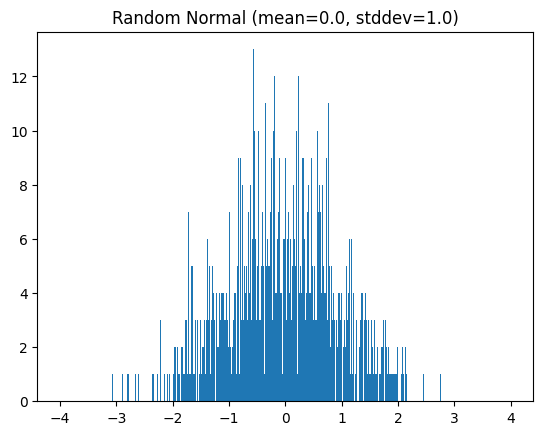

In [37]:
helpers.hist_dist('Random Normal (mean=0.0, stddev=1.0)', np.random.normal(size=[1000]))

In [38]:
def weights_init_normal(m):
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

The following shows the comparison of the normal distribution against the previous, rule-based, uniform distribution.

In [39]:
model_uniform_rule = Classifier()
model_uniform_rule.apply(weights_init_uniform_rule)

model_normal_rule = Classifier()
model_normal_rule.apply(weights_init_normal)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

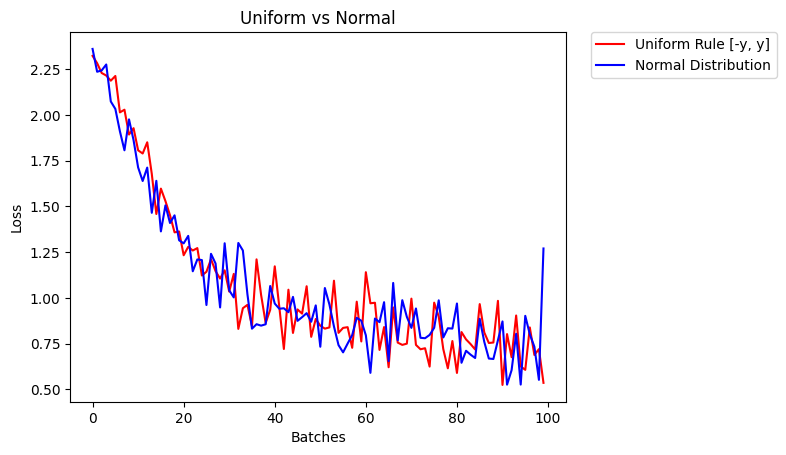

After 2 Epochs:
Validation Accuracy
   83.790% -- Uniform Rule [-y, y]
   84.410% -- Normal Distribution
Training Loss
    0.680  -- Uniform Rule [-y, y]
    0.500  -- Normal Distribution


In [40]:
model_list = [(model_uniform_rule, 'Uniform Rule [-y, y]'),
              (model_normal_rule, 'Normal Distribution')]

helpers.compare_init_weights(model_list,
                             'Uniform vs Normal',
                             trainloader,
                             testloader)

The normal distribution gives us pretty similar behavior compared to the uniform distribution, in this case. In general, a normal distribution will result in better performance for a model.

## Default weight initialization

In [41]:
model_no_initialization = Classifier()

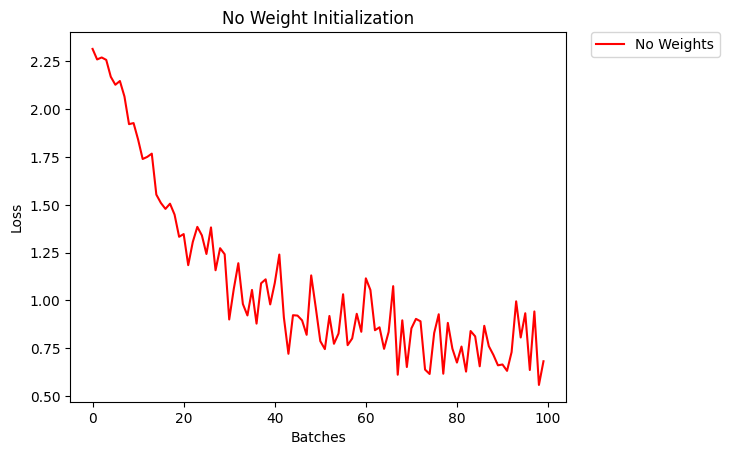

After 2 Epochs:
Validation Accuracy
   84.110% -- No Weights
Training Loss
    0.344  -- No Weights


In [42]:
model_list = [(model_no_initialization, 'No Weights')]

helpers.compare_init_weights(model_list,
                             'No Weight Initialization',
                             trainloader,
                             testloader)